In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,recall_score
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate,GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

In [14]:
def data_ingestion(data_path):
    iris_df = pd.read_csv(data_path,
                 names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'],
                 header = None)
    print("Sample records from input dataframe:")
    
    print(iris_df.head(5))
    print("\n####################################################\n")
    return iris_df

In [15]:
def dataset_insights(iris_df):
    print(iris_df.info())
    sns.pairplot(iris_df, hue = 'species', diag_kind= 'kde')
    plt.show()

In [16]:
def data_preparation(iris_df):
    iris_trans=iris_df.copy()
    le=LabelEncoder()
    iris_trans["species"]=le.fit_transform(iris_trans["species"])
    
    print("Sample records after label encoding:")
    print(iris_trans.sample(n=6))
    print("\n####################################################\n")

    print("Distribution of species - value_counts:")
    print(iris_trans["species"].value_counts())
    print("\n####################################################\n")
    le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_mapping)

    X = iris_trans.iloc[:,:-1]
    y = iris_trans.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=5,stratify=y)
    print("X_train shape :{}".format(X_train.shape))
    print("X_test shape :{}".format(X_test.shape))
    print("y_train shape :{}".format(y_train.shape))
    print("y_test shape :{}".format(y_test.shape))
    print("\n####################################################\n")
    return X, y, X_train, X_test, y_train, y_test

In [17]:
def model_training():
    
    ml_pipelines = {"DTree": make_pipeline(DecisionTreeClassifier()),
                    "RF": make_pipeline(RandomForestClassifier()) }
    
    ### Function to execution all the defined ML pipelines in loop
    model_results=[]
    ### Execute all models defined in pipelines and get the accuracy scores
    for model in ml_pipelines.keys():
        res={}
        base_model = ml_pipelines[model]
        print(base_model)
        base_model.fit(X_train, y_train)
        
        res["model_name"]=model
        res["train_score"]=base_model.score(X_train, y_train.values.ravel())
        res["test_score"]=base_model.score(X_test, y_test.values.ravel())
        predicted_labels = base_model.predict(X_test)
        res["accuracy_score"]=accuracy_score(y_test.values.ravel(), predicted_labels) * 100
        model_results.append(res)
        print_metrics(base_model,X, y, X_train,y_train,X_test,y_test)

    ### Convert the model_results to pandas daatframe and display
    print("-------Completed all pipelines-------")

    results_df=pd.DataFrame(model_results)
    return results_df

In [18]:
### Function to find the best parameters for the Gradient Boosting Classifier model
def finding_best_parameters():
    param_grid = {'max_features': ['auto', 'log2', 'sqrt'],
                  'ccp_alpha': [0.1, .01, .001, 1],
                  'max_depth' : [4, 5, 6, 7],
                  'criterion' :['gini', 'entropy']
                 }
    d_tree = DecisionTreeClassifier(random_state=5)
    grid_search = GridSearchCV(estimator=d_tree, param_grid=param_grid, cv=5, verbose=True)
    grid_search.fit(X_train, y_train)

    print("\n############## GridSearch results ##################\n")
    print( "\nBest Estimator               : {}".format(grid_search.best_estimator_))
    print( "\nBest Params                  : {}".format(grid_search.best_params_))
    print( "\nBest Scores                  : {}".format(grid_search.best_score_))
    print( "\nScore accuracy for train dataset : {}".format(grid_search.score(X_train, y_train)))
    print( "\nScore accuracy for test dataset  : {}".format(grid_search.score(X_test, y_test)))
    print("\n####################################################\n")

In [19]:
### Function to save the tuned model as pickle file
def save_tuned_model(file_name):
    ###create a model using the best parameters identified 
    dtree_tuned = DecisionTreeClassifier(ccp_alpha=0.01,criterion='entropy',max_depth=4,max_features='auto')

    dtree_tuned.fit(X_train, y_train.values.ravel())
    pickle.dump(dtree_tuned, open(file_name, 'wb'))

In [20]:
### Function to load the model using teh pickle file provided
def load_model(file_name):
    loaded_model = pickle.load(open(file_name, 'rb'))
    
    return loaded_model

In [21]:
### Function for getting and displaying score
def print_metrics(model,X, y, X_train,y_train,X_test,y_test):
    model_str=str(model).split("\'")
    model_name=model_str[1]
    if model_name=='entropy':
        model_name='DecisionTree_tuned_model'
    
    y_pred = model.predict(X_test)
    
    ## Print classification report
    
    print("Classification report for {}:\n{}".format(model_name, metrics.classification_report(y_test, y_pred)))

    ## Print Cross-Validation results    
    scoring = {'precision_macro': 'precision_macro',
                'recall_macro': metrics.make_scorer(recall_score, average='micro')}
    cv_scores = cross_validate(model, X, y.values.ravel(),scoring=scoring,cv=StratifiedKFold(n_splits=5, shuffle=True, 
                                                                                             random_state=10))
    for c in cv_scores:
        print("Metric: {}, Mean_value: {}".format(c,np.mean(cv_scores[c])))
    
    ### Print the confusion matrix for train dataset
    print("Confusion Matrix for {} - train dataset is printed below:".format(model_name))
    cm_train=metrics.confusion_matrix(y_train, model.predict(X_train), labels=[0,1,2])
    df_cm_train = pd.DataFrame(cm_train, index = [i for i in ["Iris-setosa","Iris-versicolor","Iris-virginica"]],
                      columns = [i for i in ["Iris-setosa","Iris-versicolor","Iris-virginica"]])
    plt.figure(figsize = (4,4))
    plt.title("Confusion Matrix for {} - train dataset".format(model_name))
    sns.heatmap(df_cm_train, annot=True,fmt='g')
    
    ### Print the confusion matrix for test dataset
    print("Confusion Matrix for {} - test dataset is printed below:".format(model_name))
    cm_test=metrics.confusion_matrix(y_test, model.predict(X_test), labels=[0,1,2])
    df_cm_test = pd.DataFrame(cm_test, index = [i for i in ["Iris-setosa","Iris-versicolor","Iris-virginica"]],
                      columns = [i for i in ["Iris-setosa","Iris-versicolor","Iris-virginica"]])
    plt.figure(figsize = (4,4))
    plt.title("Confusion Matrix for {} - test dataset:".format(model_name))
    sns.heatmap(df_cm_test, annot=True,fmt='g')
    print("\n####################################################\n")

In [22]:
### Function to calculate scores and also print various metrics like 
### classification report,mean values of scoring metrics, confusion metrics etc
def model_scoring(model,X, y, X_train,y_train,X_test,y_test):
    train_results=model.score(X_train, y_train)
    test_results=model.score(X_test, y_test)
    print("Train score results :{}".format(train_results))
    print("Test score results  :{}".format(test_results))
    
    ### Print Classification report and Cross-Validation results
    print_metrics(model,X, y, X_train,y_train,X_test,y_test)

Sample records from input dataframe:
   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

####################################################

Sample records after label encoding:
    sepal_length  sepal_width  petal_length  petal_width  species
9            4.9          3.1           1.5          0.1        0
0            5.1          3.5           1.4          0.2        0
21           5.1          3.7           1.5          0.4        0
18           5.7          3.8           1.7          0.3        0
54           6.5          2.8           4.6          1.5        1
81           5.5          2.4           3.7          1.0     

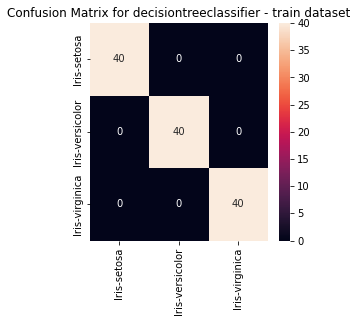

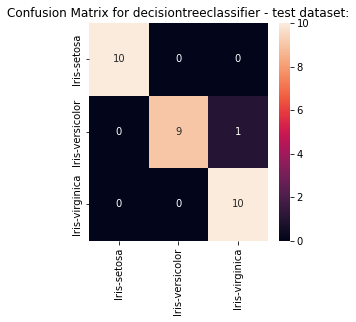

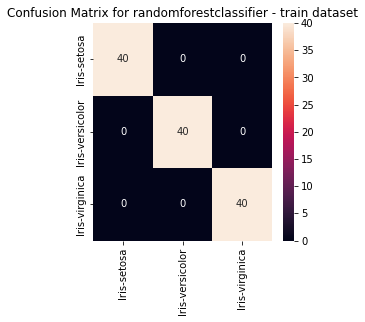

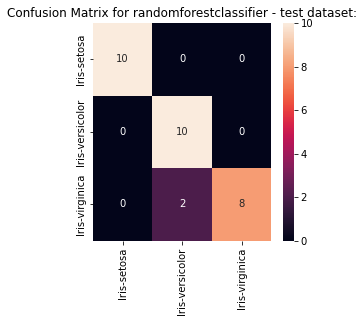

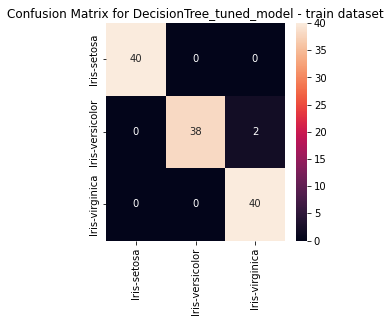

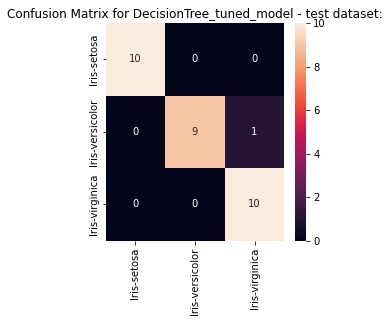

In [23]:
if __name__ == '__main__':
    try:
        # Extract the data from list of .csv files
        data_path='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
        
        # Data ingestion
        iris_df=data_ingestion(data_path)
        
        # Data Preparation
        X, y, X_train, X_test, y_train, y_test=data_preparation(iris_df)
        
        # Model training for defined ML pipelines
        train_results=model_training()
        
        print("#### Showing model training results of models defined in ML pipelines ####")
        print(train_results.head(10))
        print("\n####################################################\n")
    
        # Find the best parameter for Decision Tree model
        finding_best_parameters()

        # Save the fine tuned model as pickle file
        file_name='dtree_tuned_model.pkl'
        save_tuned_model(file_name)

        # Load the fine tuned model from pickle file and print various metrics for the tuned model
        loaded_model=load_model(file_name)
        model_scoring(loaded_model,X,y,X_train,y_train,X_test,y_test)

    except Exception as e:
        print("Exception is raised and the error is :{}".format(e))
        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


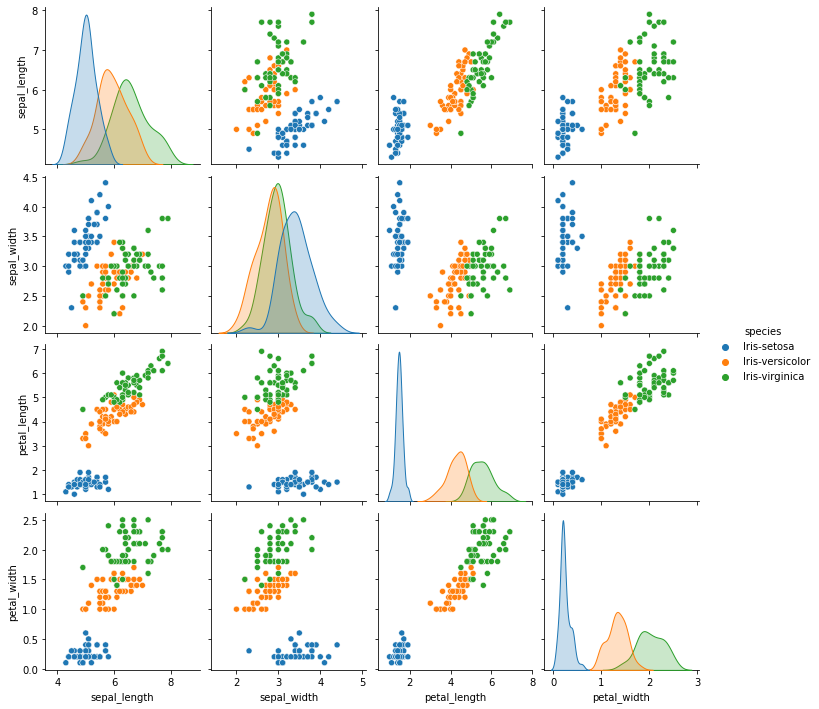

In [96]:
dataset_insights(iris_df)

In [97]:
iris_df['species'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: species, dtype: int64

In [98]:
iris_df.sample(n=10)

,sepal_length,sepal_width,petal_length,petal_width,species
44,5.1,3.8,1.9,0.4,Iris-setosa
77,6.7,3.0,5.0,1.7,Iris-versicolor
45,4.8,3.0,1.4,0.3,Iris-setosa
128,6.4,2.8,5.6,2.1,Iris-virginica
135,7.7,3.0,6.1,2.3,Iris-virginica
36,5.5,3.5,1.3,0.2,Iris-setosa
145,6.7,3.0,5.2,2.3,Iris-virginica
117,7.7,3.8,6.7,2.2,Iris-virginica
114,5.8,2.8,5.1,2.4,Iris-virginica
1,4.9,3.0,1.4,0.2,Iris-setosa
